## Plots for l'Aquila - Summary of all results
### Using: EPOS-LHC AixNet new data set with old baseline
This notebook produces summary plots of all the dipole analysis

### Evaluating best dipole parameters
Commented because using Emily's values

In [1]:
from simulated_dipole import *
import matplotlib.pyplot as plt

# globally setting d_max
d_max = 1

# calling the class for dipole parameters
'''
dp = dipole_parameters('EPOS', d_max, 100) # which model, which dmax, how many steps 
res, d, beta = dp.evaluate() # results to plot, optimal dipole amplitude, optimal beta
'''

"\ndp = dipole_parameters('EPOS', d_max, 100) # which model, which dmax, how many steps \nres, d, beta = dp.evaluate() # results to plot, optimal dipole amplitude, optimal beta\n"

In [2]:
'''
# plotting only a region of the parameters space
uni_d_r = np.unique(res['d_r'])
uni_beta_r = np.unique(res['beta_r'][(res['beta_r']>0.8)*((res['beta_r']<=2.6))])


# preparing the grid
grid = np.zeros((len(uni_beta_r), len(uni_d_r)))

for i, h in enumerate(uni_beta_r):
    for j, l in enumerate(uni_d_r):
        mask = (res['beta_r']==h) & (res['d_r']==l)
        if np.any(mask):
            grid[i, j] = res['chisq'][mask][0]


plt.figure(figsize=(10, 6))
# plt.title(rf'$d_\mathrm{{max}}={d_max}$')
cmap = plt.cm.plasma_r
plt.imshow((grid)/1, aspect='auto', origin='lower',
           extent=[uni_d_r.min(), uni_d_r.max(),
                    uni_beta_r.min(), uni_beta_r.max()],
            cmap=cmap, vmin=0, vmax=5)
dot_y = uni_beta_r[np.where(grid==np.min(grid))[0]][0]
dot_x = uni_d_r[np.where(grid==np.min(grid))[1]][0]
plt.plot(dot_x, dot_y, ls='', marker='o', color='w', markersize=5)
plt.text(dot_x+0.0005, dot_y, rf'$({float(dot_x):.4f},\, {float(dot_y):.1f})$', color='w')
plt.colorbar(label=r'$\chi^2/$ndf')
plt.xlabel(r'$d_R$')
plt.ylabel(r'$\beta_R$')
yticks = np.arange(1.0, 2.6, 0.3)
plt.yticks(yticks, size='medium')
xticks = np.arange(0.002, 0.021, 0.004)
plt.xticks(xticks, size='medium')
plt.show()
'''

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_100305/1101035863.py:1: SyntaxWarning: invalid escape sequence '\m'
  '''


"\n# plotting only a region of the parameters space\nuni_d_r = np.unique(res['d_r'])\nuni_beta_r = np.unique(res['beta_r'][(res['beta_r']>0.8)*((res['beta_r']<=2.6))])\n\n\n# preparing the grid\ngrid = np.zeros((len(uni_beta_r), len(uni_d_r)))\n\nfor i, h in enumerate(uni_beta_r):\n    for j, l in enumerate(uni_d_r):\n        mask = (res['beta_r']==h) & (res['d_r']==l)\n        if np.any(mask):\n            grid[i, j] = res['chisq'][mask][0]\n\n\nplt.figure(figsize=(10, 6))\n# plt.title(rf'$d_\\mathrm{{max}}={d_max}$')\ncmap = plt.cm.plasma_r\nplt.imshow((grid)/1, aspect='auto', origin='lower',\n           extent=[uni_d_r.min(), uni_d_r.max(),\n                    uni_beta_r.min(), uni_beta_r.max()],\n            cmap=cmap, vmin=0, vmax=5)\ndot_y = uni_beta_r[np.where(grid==np.min(grid))[0]][0]\ndot_x = uni_d_r[np.where(grid==np.min(grid))[1]][0]\nplt.plot(dot_x, dot_y, ls='', marker='o', color='w', markersize=5)\nplt.text(dot_x+0.0005, dot_y, rf'$({float(dot_x):.4f},\\, {float(dot_y):

In [3]:
# define classes for later
es = energy_spectrum()
dip = simulated_dipole('EPOS')
mf = mass_fractions('EPOS')

# fixing parameters found in simulations, if not, using Emily's values
# dip.d_r = d
# dip.beta_r = beta

'''
ene = np.linspace(np.log10(3e18),np.log10(200e18), num=1000)
dtot = np.zeros_like(ene)

plt.figure(figsize=(10,6))
# plt.title(rf'Model: EPOS-LHC, $d_\mathrm{{max}}={d_max}$')
for name in names:
    if name == 'Fe':
        ddd = dp.dipole_func(name, np.power(10, ene - 18), d, beta, d_max)*(1 - (mf.fraction_func('p', ene) + mf.fraction_func('He', ene) + mf.fraction_func('CNO', ene)))
        plt.plot(ene, ddd, label=f'{name}', linewidth=4, color=colors[name])
        dtot += ddd
    else:
        ddd = dp.dipole_func(name, np.power(10, ene - 18), d, beta, d_max)*mf.fraction_func(name, ene)
        plt.plot(ene, ddd, label=f'{name}', linewidth=4, color=colors[name])
        dtot += ddd
for i in range(len(energies[:-1])):
    if i>=1: # skipping the first bin 4-8 EeV
        E = energies[i]
        Eplus = energies[i+1]
        enetwo = np.linspace(E, Eplus)
        Z_sum = np.zeros_like(enetwo)
        for name in charges:
            if name == 'Fe':
                Z_sum += dip.dipole_dependence(name, enetwo/1e18, d_max)*(1 - (mf.fraction_func('p', np.log10(enetwo)) + mf.fraction_func('He', np.log10(enetwo)) + mf.fraction_func('CNO', np.log10(enetwo))))
            else:
                Z_sum += dip.dipole_dependence(name, enetwo/1e18, d_max)*mf.fraction_func(name, np.log10(enetwo))
        plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=4, color='darkgrey')
        plt.axvline(np.log10(E), lw=4, color='darkgrey', ls=':')
plt.errorbar(np.log10(1.5*mid_ene), dipole_values, yerr=dipole_errors, ls='', marker='o', color='darkred')
plt.plot(ene, dtot, label='all', linewidth=4, color='k')
plt.xlabel(r'$\log_{10}(E/\, \mathrm{eV})$')
plt.ylabel('dipole amplitude')
plt.ylim(1e-2, 1)
plt.xlim(18.5, 19.8)
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()
'''

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_100305/3175242167.py:10: SyntaxWarning: invalid escape sequence '\m'
  '''


"\nene = np.linspace(np.log10(3e18),np.log10(200e18), num=1000)\ndtot = np.zeros_like(ene)\n\nplt.figure(figsize=(10,6))\n# plt.title(rf'Model: EPOS-LHC, $d_\\mathrm{{max}}={d_max}$')\nfor name in names:\n    if name == 'Fe':\n        ddd = dp.dipole_func(name, np.power(10, ene - 18), d, beta, d_max)*(1 - (mf.fraction_func('p', ene) + mf.fraction_func('He', ene) + mf.fraction_func('CNO', ene)))\n        plt.plot(ene, ddd, label=f'{name}', linewidth=4, color=colors[name])\n        dtot += ddd\n    else:\n        ddd = dp.dipole_func(name, np.power(10, ene - 18), d, beta, d_max)*mf.fraction_func(name, ene)\n        plt.plot(ene, ddd, label=f'{name}', linewidth=4, color=colors[name])\n        dtot += ddd\nfor i in range(len(energies[:-1])):\n    if i>=1: # skipping the first bin 4-8 EeV\n        E = energies[i]\n        Eplus = energies[i+1]\n        enetwo = np.linspace(E, Eplus)\n        Z_sum = np.zeros_like(enetwo)\n        for name in charges:\n            if name == 'Fe':\n         

### Example of cuts estimation on a simulated sample

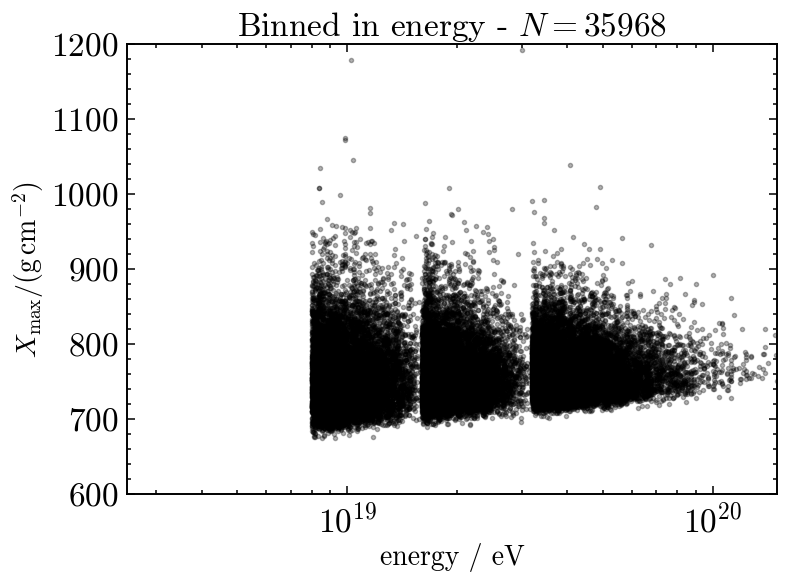

Remaining events above 8 EeV: 35968


In [4]:
dd = file_loader('AixNet_EPOS_old')

mass_mask = mf.extract_all_fractions(np.log10(dd['energy'])+18, dd['mass']) 
dd = dict_cutter(dd, mass_mask)

temp_dict = [{} for i in range(4)]
for i in range(len(energies[:-1])):
    enne = energies[i]/1e18
    enneplus = energies[i+1]/1e18
    energy_mask = (dd['energy']>=enne)&(dd['energy']<enneplus)
    temp_dict[i] = dict_cutter(dd, energy_mask)
    spectrum_mask = es.spectrum_fraction(temp_dict[i]['energy'])
    temp_dict[i] = dict_cutter(temp_dict[i], spectrum_mask)

dd = dict_paster(temp_dict)

dd['charge'] = np.empty_like(dd['mass'])
for mass in names:
    dd['charge'][np.where(dd['mass']==names[mass])]=charges[mass]

plt.figure(figsize=(10,6))
plt.title(f'Binned in energy - $N ={len(dd['energy'][dd['energy']>=8]):.0f}$')
plt.scatter(dd['energy'][dd['energy']>=8]*1e18, dd['dnn_xmax'][dd['energy']>=8], alpha=0.3, color='k')
plt.xlabel(r'energy / eV')
plt.ylabel(r'$X_\mathrm{max} / \mathrm{(g \, cm^{-2})}$')
plt.xscale('log')
plt.ylim(600, 1200)
plt.xlim(2.5e18, 150e18)
plt.show()

print('Remaining events above 8 EeV:', len(dd['energy'][dd['energy']>=8]))

8.0 n= 11629
16.0 n= 10309
32.0 n= 14030


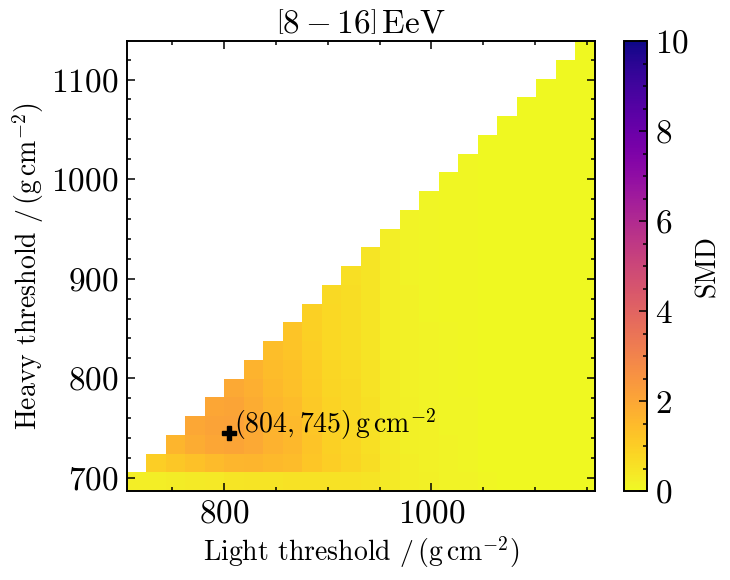

light fraction: [0.16536246]
heavy fraction: [0.40863359]


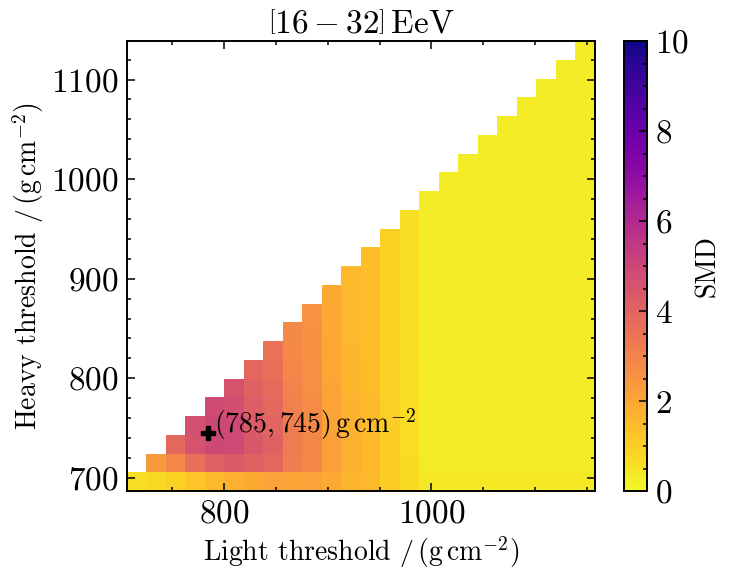

light fraction: [0.16732952]
heavy fraction: [0.54175963]


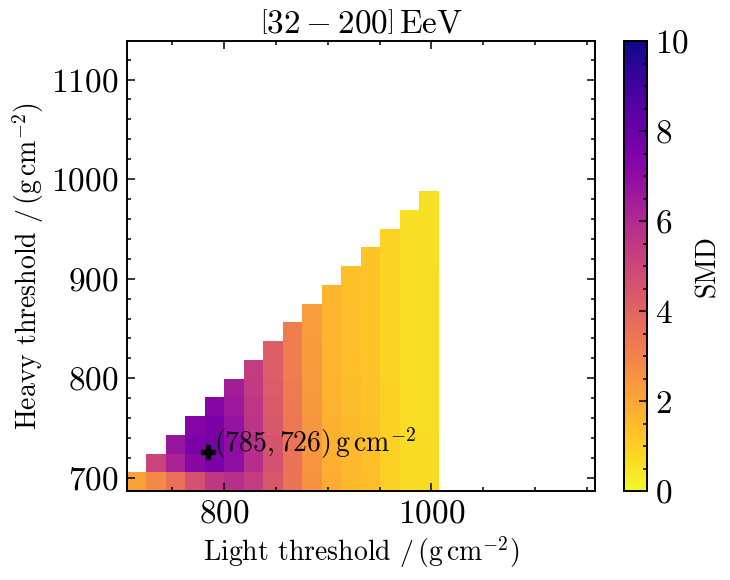

light fraction: [0.0743407]
heavy fraction: [0.51910192]


In [5]:
energies = np.array([8e18, 16e18, 32e18, 200e18]) # redefining excluding first bin
smd = SMD_method(model='EPOS')

# fixing parameters found in simulations, if not, using Emily's values
# smd.sd.beta_r = beta
# smd.sd.d_r = d

generate_xmax19(dd, 'dnn_xmax', 'energy')

thres_values = np.linspace(np.min(dd['xmax19']), np.max(dd['xmax19']), 27)
# print(thres_values)
results_dict = {'emin': [], 
                'emax': [], 
                'light': [], 
                'heavy': [], 
                'N_light': [],
                'N_heavy': [],
                'N_tot': [],
                'SMD': [], 
                'lnA_light': [],
                'lnA_heavy': []
                }

for ee in range(len(energies)-1):
    e_min = energies[ee]/1e18
    e_max =energies[ee+1]/1e18

    e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
    data = dict_cutter(dd, e_mask)
    print(e_min, 'n=', len(data['energy']))

    for i in range(1, len(thres_values) - 2):
        thres_h = thres_values[i]

        for j in range(i + 1, len(thres_values) - 1):

            thres_l = thres_values[j]
            mask_h = (data['xmax19']<thres_h)
            mask_l = (data['xmax19']>thres_l)
            light_frac = dict_cutter(data, mask_l)
            heavy_frac = dict_cutter(data, mask_h)

            value = smd.quantify_SMD(light_frac['energy'], light_frac['charge'], heavy_frac['energy'], heavy_frac['charge'], d_max=d_max)
            A_l = np.sum(np.log(light_frac['mass']))
            A_h = np.sum(np.log(heavy_frac['mass']))

            results_dict['emin'].append(e_min)
            results_dict['emax'].append(e_max)
            results_dict['light'].append(thres_l)
            results_dict['heavy'].append(thres_h)
            results_dict['SMD'].append(value)
            results_dict['N_light'].append(len(light_frac['xmax19']))
            results_dict['N_heavy'].append(len(heavy_frac['xmax19']))
            results_dict['N_tot'].append(len(data['xmax19']))
            results_dict['lnA_light'].append(A_l/len(data['xmax19']))
            results_dict['lnA_heavy'].append(A_h/len(data['xmax19']))



for key, value in results_dict.items():
    results_dict[key] = np.array(value)

heavy_cut = []
light_cut = []

for i in range(len(energies[:-1])):
    ene = energies[i]
    eneplus = energies[i+1]
    light_vals = np.array(results_dict['light'][results_dict['emin']==ene/1e18])
    heavy_vals = np.array(results_dict['heavy'][results_dict['emin']==ene/1e18])
    SMD_vals = np.array(results_dict['SMD'][results_dict['emin']==ene/1e18])
    # Create grid
    unique_light = np.unique(light_vals)  # Unique x values
    unique_heavy = np.unique(heavy_vals)  # Unique y values

    # Reshape SMD values into a 2D array
    SMD_grid = np.zeros((len(unique_heavy), len(unique_light)))

    for i, h in enumerate(unique_heavy):
        for j, l in enumerate(unique_light):
            mask = (heavy_vals == h) & (light_vals == l)
            if np.any(mask):
                SMD_grid[i, j] = SMD_vals[mask][0]  # Take first match

    masked_SMD = np.ma.masked_where((unique_light[None, :] <= unique_heavy[:, None])|(SMD_grid<=0), SMD_grid)
    # heatmap with absolute value
    plt.figure(figsize=(9, 6))
    plt.title(rf'$\left[{ene/1e18:.0f}-{eneplus/1e18:.0f} \right] \, \mathrm{{EeV}}$')
    cmap = plt.cm.plasma_r.copy()
    cmap.set_bad(color='white')  # Set masked values to white

    plt.imshow(masked_SMD, aspect='auto', origin='lower',
            extent=[unique_light.min(), unique_light.max(),
                    unique_heavy.min(), unique_heavy.max()],
            cmap=cmap, vmin=0, vmax=10)
    dot_x = (unique_light[np.where(SMD_grid==SMD_grid.max())[1]])[0]
    dot_y =  (unique_heavy[np.where(SMD_grid==SMD_grid.max())[0]])[0]
    plt.text(dot_x+5, dot_y, rf'$({float(dot_x):.0f},{float(dot_y):.0f}) \, \mathrm{{g \, cm^{{-2}}}}$')
    plt.plot(dot_x, dot_y, ls='', marker='P', color='k', markersize=10)
    plt.colorbar(label='SMD')
    plt.xlabel(r'Light threshold $/ \, \mathrm{(g \, cm^{-2})}$')
    plt.ylabel(r'Heavy threshold $/ \, \mathrm{(g \, cm^{-2})}$')
    plt.show()

    best_pos = np.where((results_dict['light']==dot_x)&(results_dict['heavy']==dot_y)&(results_dict['emin']==ene/1e18))
    print('light fraction:', results_dict['N_light'][best_pos]/results_dict['N_tot'][best_pos])
    print('heavy fraction:', results_dict['N_heavy'][best_pos]/results_dict['N_tot'][best_pos])

    heavy_cut.append(dot_y)
    light_cut.append(dot_x)

### Discovery potential
Caveat: as the plot Energy/Xmax shows, I have high statistics in the last bin! That's why the error bars are so small. To produce a nice discovery potential plot, one should extract the spectrum not binned by energy, but only one bin

8.0 n= 11629
16.0 n= 10309
32.0 n= 14030


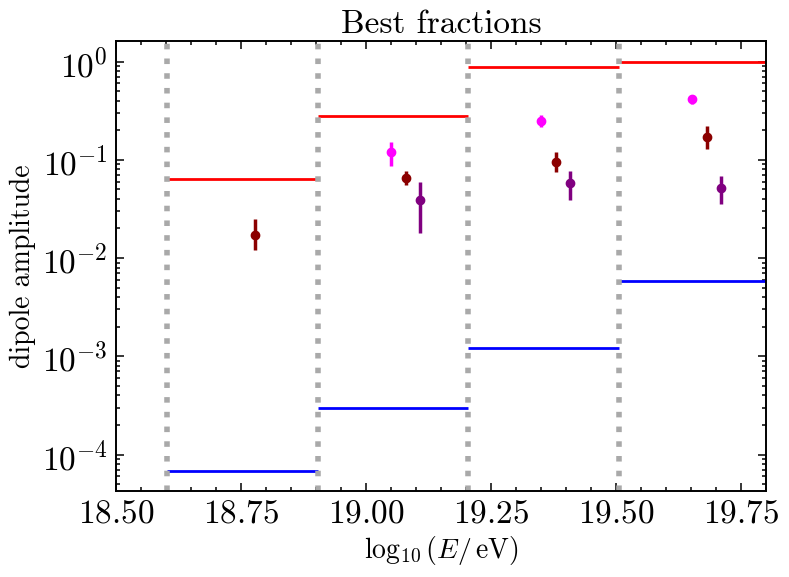

In [6]:
energies = np.array([4e18, 8e18, 16e18, 32e18, 200e18])
# print(dip.beta_r)

plt.figure(figsize=(10,6))
plt.title(r'Best fractions')
for i in range(len(energies[:-1])):

    if i>=1:
        e_min = energies[i]/1e18
        e_max =energies[i+1]/1e18
        e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
        data = dict_cutter(dd, e_mask)
        print(e_min, 'n=', len(data['energy']))
        mask_h = (data['xmax19']<heavy_cut[i-1])
        mask_l = (data['xmax19']>light_cut[i-1])
        light_frac = dict_cutter(data, mask_l)
        heavy_frac = dict_cutter(data, mask_h)
        dip_l, err_l = smd.dipole_value(light_frac['energy'],light_frac['charge'], d_max=d_max)
        dip_h, err_h = smd.dipole_value(heavy_frac['energy'], heavy_frac['charge'], d_max=d_max)
        plt.errorbar(np.log10(1.4*mid_ene[i]), dip_l, yerr=err_l, ls='', marker='o', color='fuchsia')
        plt.errorbar(np.log10(1.6*mid_ene[i]), dip_h, yerr=err_h, ls='', marker='o', color='purple')

    E = energies[i]
    Eplus = energies[i+1]
    enetwo = np.linspace(E, Eplus)
    Z_sum_Fe = np.zeros_like(enetwo)
    Z_sum_p = np.zeros_like(enetwo)
    for name in charges:
        if name == 'Fe':
            Z_sum_Fe = dip.dipole_dependence(name, enetwo/1e18, d_max)# *(1 - (mf.fraction_func('p', np.log10(enetwo)) + mf.fraction_func('He', np.log10(enetwo)) + mf.fraction_func('CNO', np.log10(enetwo))))
        if name == 'p':
            Z_sum_p = dip.dipole_dependence(name, enetwo/1e18, d_max)# *mf.fraction_func(name, np.log10(enetwo))
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum_Fe)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=2, color='blue')
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum_p)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=2, color='red')
    plt.axvline(np.log10(E), lw=4, color='darkgrey', ls=':')
plt.errorbar(np.log10(1.5*mid_ene), dipole_values, yerr=dipole_errors, ls='', marker='o', color='darkred')
plt.xlabel(r'$\log_{10}(E/\, \mathrm{eV})$')
plt.ylabel('dipole amplitude')
plt.xlim(18.5, 19.8)
#plt.xlim(18.5, 20.2)
plt.yscale('log')
# plt.legend(loc='upper left')
plt.show()

### Cuts optimization

In [7]:
energies = np.array([8e18, 16e18, 32e18, 200e18]) # redefining excluding first bin

keys_to_extract = ['dnn_xmax', 'energy', 'mass'] # energy in EeV
ddd = file_loader('AixNet_EPOS_old') # remember to change also which key is used in `generate_xmax19()`


ddd = {kk: ddd[kk] for kk in keys_to_extract if kk in ddd} # to get a faster cycle
ddd = remove_nan_entries(ddd) # needed for KAne
ene_mask = (ddd['energy']>=8)
ddd = dict_cutter(ddd, ene_mask)


print(ddd.keys())
print('Number of simulated events above 8 EeV:', len(ddd['energy']))


# All necessary items for random samples are here
n_samples = 1000
# these are the starting seeds for all the random generators, that are fixed and each different
seed_2 = np.arange(2*n_samples,3*n_samples)
seed_3 = np.arange(3*n_samples,4*n_samples)

final_results = {'iter': [], 'emin': [], 'light': [], 'heavy': [], 'frac_l': [], 'frac_h': [], 'SMD': []}

# for k in range(n_samples):

#     print('\rIteration:', k+1, ' of ', n_samples, end='')
#     dd = ddd # here I make a copy, so that I can modify it (ddd stays the same for all cycles)
#     # print('Original length:', len(dd['energy']))

#     # extract mass fractions
#     mf.seed = seed_2[k] # fix seed
#     mass_mask = mf.extract_all_fractions(np.log10(dd['energy'])+18, dd['mass']) # log(E/eV) is needed here
#     dd = dict_cutter(dd, mass_mask)
#     # print('After mass fractions:', len(dd['energy']))

#     # extract spectrum (bin-wise)
#     es.seed = seed_3[k] # fix seed
#     temp_dict = [{} for i in range(3)]
#     for i in range(len(energies[:-1])):
#         enne = energies[i]/1e18
#         enneplus = energies[i+1]/1e18
#         energy_mask = (dd['energy']>=enne)&(dd['energy']<enneplus)
#         temp_dict[i] = dict_cutter(dd, energy_mask)
#         spectrum_mask = es.spectrum_fraction(temp_dict[i]['energy'])
#         temp_dict[i] = dict_cutter(temp_dict[i], spectrum_mask)

#     dd = dict_paster(temp_dict)
#     # print('After energy spectrum:', len(dd['energy']))

#     # define charge
#     dd['charge'] = np.empty_like(dd['mass'])
#     for mass in names:
#         dd['charge'][np.where(dd['mass']==names[mass])]=charges[mass]

#     generate_xmax19(dd, 'dnn_xmax', 'energy')
    
#     # estimate best quantiles
#     thres_values = np.linspace(np.min(dd['xmax19']), np.max(dd['xmax19']), 27) # 25 values + 2 border values
#     res = { 'emin': [], 
#             'light': [], 
#             'heavy': [], 
#             'N_light': [],
#             'N_heavy': [],
#             'N_tot': [],
#             'SMD': [],
#             }
    
#     for ee in range(len(energies)-1):
#         e_min = energies[ee]/1e18
#         e_max =energies[ee+1]/1e18


#         # extract energy range
#         e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
#         data = dict_cutter(dd, e_mask)

#         for i in range(1, len(thres_values) - 2):
#             thres_h = thres_values[i]

#             for j in range(i + 1, len(thres_values) - 1):

#                 thres_l = thres_values[j]
#                 mask_h = (data['xmax19']<thres_h)
#                 mask_l = (data['xmax19']>thres_l)
#                 light_frac = dict_cutter(data, mask_l)
#                 heavy_frac = dict_cutter(data, mask_h)

#                 value = smd.quantify_SMD(light_frac['energy'], light_frac['charge'], heavy_frac['energy'], heavy_frac['charge'], d_max=d_max)
#                 A_l = np.sum(np.log(light_frac['mass']))
#                 A_h = np.sum(np.log(heavy_frac['mass']))

#                 res['emin'].append(e_min)
#                 res['light'].append(thres_l)
#                 res['heavy'].append(thres_h)
#                 res['SMD'].append(value)
#                 res['N_light'].append(len(light_frac['xmax19']))
#                 res['N_heavy'].append(len(heavy_frac['xmax19']))
#                 res['N_tot'].append(len(data['xmax19']))

#     for key, value in res.items():
#         res[key] = np.array(value)

#     # format final results
#     for l in range(len(energies[:-1])):

#         emin_val = energies[l] / 1e18
#         mask = res['emin'] == emin_val

#         smd_vals = res['SMD'][mask]
#         max_pos = np.argmax(smd_vals)

#         valid_indices = np.where(mask)[0]

#         idx = valid_indices[max_pos]
#         n_tot = res['N_tot'][idx]
#         n_light = res['N_light'][idx]
#         n_heavy = res['N_heavy'][idx]

#         if n_tot == 0:
#             print(f"[WARNING] Total events is zero for energy bin {emin_val:.2f} EeV (iteration {k})")
#             frac_l = np.nan
#             frac_h = np.nan
#         else:
#             frac_l = n_light / n_tot
#             frac_h = n_heavy / n_tot

#         final_results['iter'].append(k)
#         final_results['emin'].append(emin_val)
#         final_results['light'].append(res['light'][idx])
#         final_results['heavy'].append(res['heavy'][idx])
#         final_results['frac_l'].append(frac_l)
#         final_results['frac_h'].append(frac_h)
#         final_results['SMD'].append(np.max(smd_vals))


# # Convert to pandas DataFrame
# df = pd.DataFrame(final_results)
# df.to_csv('data_results/final_final_results_aixnet_epos.csv')
# display(df)

dict_keys(['dnn_xmax', 'energy', 'mass'])
Number of simulated events above 8 EeV: 459257


8 EeV heavy median: 743, 68% interval: [733, 746], mean: 741
16 EeV heavy median: 742, 68% interval: [732, 746], mean: 740
32 EeV heavy median: 724, 68% interval: [715, 728], mean: 722


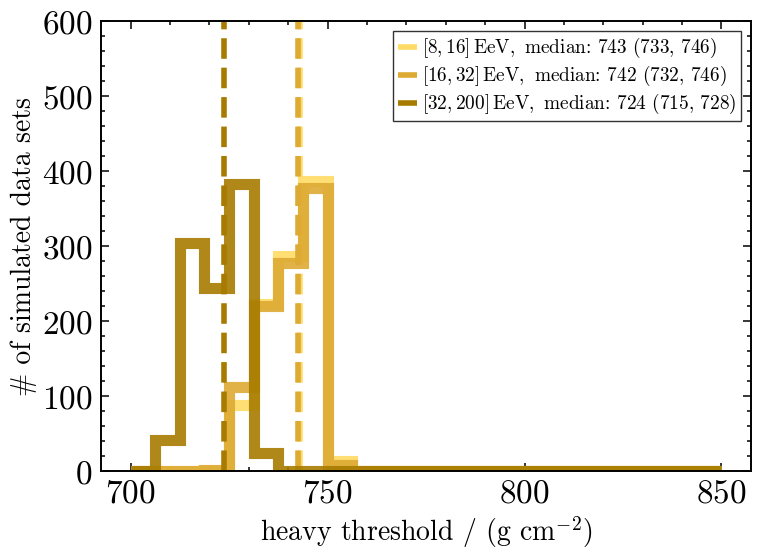

8 EeV light median: 793, 68% interval: [786, 800], mean: 793
16 EeV light median: 790, 68% interval: [783, 797], mean: 790
32 EeV light median: 781, 68% interval: [774, 786], mean: 781


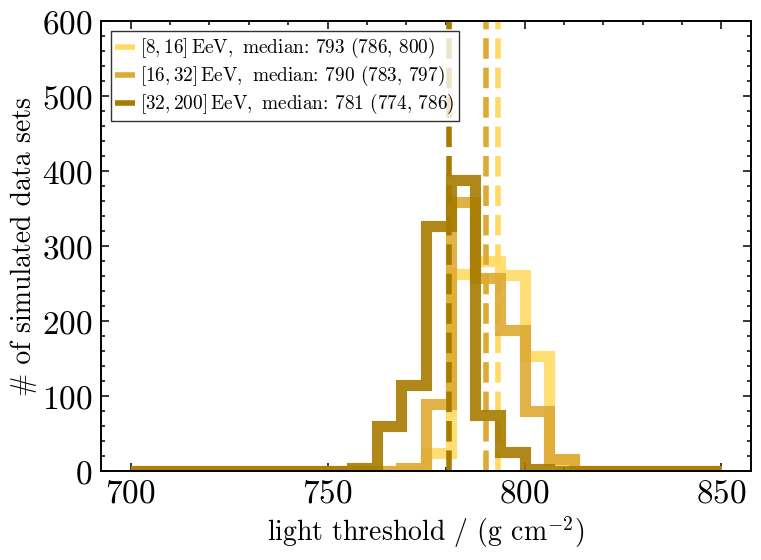

8 EeV heavy median: 0.389, 68% interval: [0.291, 0.425], mean: 0.368
16 EeV heavy median: 0.509, 68% interval: [0.395, 0.551], mean: 0.484
32 EeV heavy median: 0.497, 68% interval: [0.393, 0.546], mean: 0.477


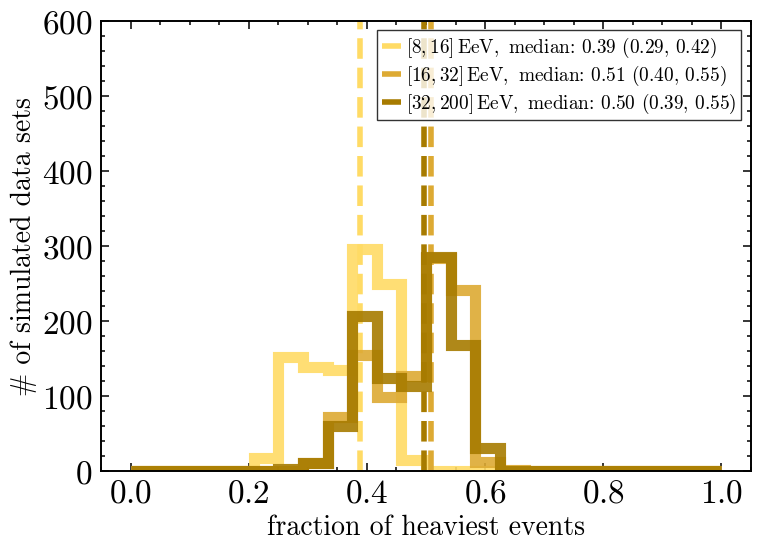

8 EeV light median: 0.216, 68% interval: [0.181, 0.260], mean: 0.219
16 EeV light median: 0.143, 68% interval: [0.114, 0.176], mean: 0.146
32 EeV light median: 0.087, 68% interval: [0.072, 0.110], mean: 0.091


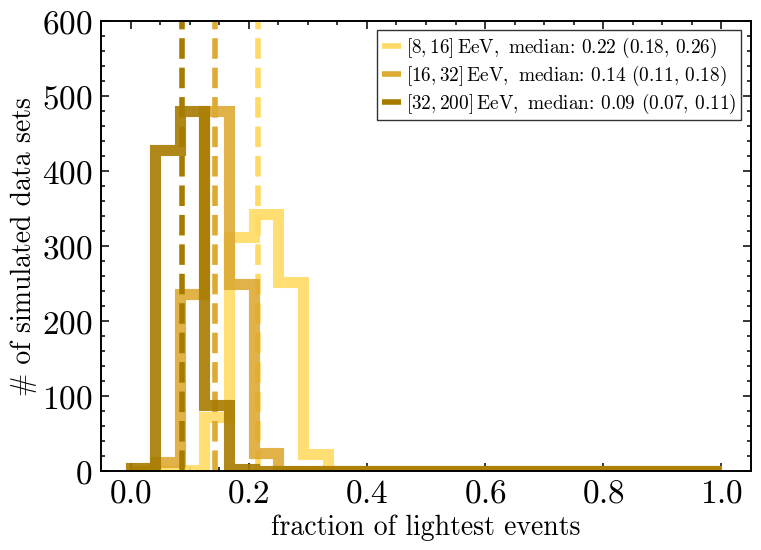

3000


In [8]:
from scipy import stats

df = pd.read_csv('data_results/final_final_results_aixnet_epos.csv')
colors ={'8': '#ffdb65', '16': '#ddaa33', '32': '#a77b00'} # AixNet

energ = [8, 16, 32, 200]
bins = np.linspace(700, 850, num=25)
heavy_thres = []
light_thres = []

plt.figure(figsize=(10,6))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['heavy'][df['emin'] == ene]
    median = np.median(data)
    mean = np.mean(data)
    heavy_thres.append(mean)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4, label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.0f} ({p16:.0f}, {p84:.0f})', color=colors[f'{ene}'])
    # plt.fill_betweenx([0, plt.gca().get_ylim()[1]], p16, p84, color=colors[f'{ene}'], alpha=0.2)

    print(f"{ene} EeV heavy median: {median:.0f}, 68% interval: [{p16:.0f}, {p84:.0f}], mean: {mean:.0f}")
plt.legend(fontsize='x-small')
plt.xlabel(r'heavy threshold / (g cm$^{-2}$)')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 600)
plt.show()


plt.figure(figsize=(10,6))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['light'][df['emin'] == ene]
    median = np.median(data)
    mean = np.mean(data)
    light_thres.append(mean)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', stacked=False, fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4, label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.0f} ({p16:.0f}, {p84:.0f})', color=colors[f'{ene}'])
    # plt.fill_betweenx([0, plt.gca().get_ylim()[1]], p16, p84, color=colors[f'{ene}'], alpha=0.2)

    print(f"{ene} EeV light median: {median:.0f}, 68% interval: [{p16:.0f}, {p84:.0f}], mean: {mean:.0f}")
plt.legend(fontsize='x-small', loc='upper left')
plt.xlabel(r'light threshold / (g cm$^{-2}$)')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 600)
plt.show()

bins = np.linspace(0, 1, num=25)
# fig, ax = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
# First subplot: light
plt.figure(figsize=(10,6))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['frac_h'][df['emin'] == ene]
    median = np.median(data)
    mean = np.mean(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4,
                  label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.2f} ({p16:.2f}, {p84:.2f})',
                  color=colors[f'{ene}'])
    print(f"{ene} EeV heavy median: {median:.3f}, 68% interval: [{p16:.3f}, {p84:.3f}], mean: {mean:.3f}")

plt.legend(fontsize='x-small')
plt.xlabel(r'fraction of heaviest events')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 600)
plt.show()
# ax[0].set_ylim(0, 0.7)

# Second subplot: heavy
plt.figure(figsize=(10,6))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['frac_l'][df['emin'] == ene]
    median = np.median(data)
    mean = np.mean(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', stacked=False, fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4,
                  label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.2f} ({p16:.2f}, {p84:.2f})',
                  color=colors[f'{ene}'])
    print(f"{ene} EeV light median: {median:.3f}, 68% interval: [{p16:.3f}, {p84:.3f}], mean: {mean:.3f}")

plt.legend(fontsize='x-small')
plt.xlabel(r'fraction of lightest events')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 600)
plt.show()

print(len(df['SMD']))

8 EeV light median: 2.008, 68% interval: [1.950, 2.067], mean: 2.009
16 EeV light median: 5.050, 68% interval: [4.873, 5.201], mean: 5.047
32 EeV light median: 7.953, 68% interval: [7.681, 8.199], mean: 7.940


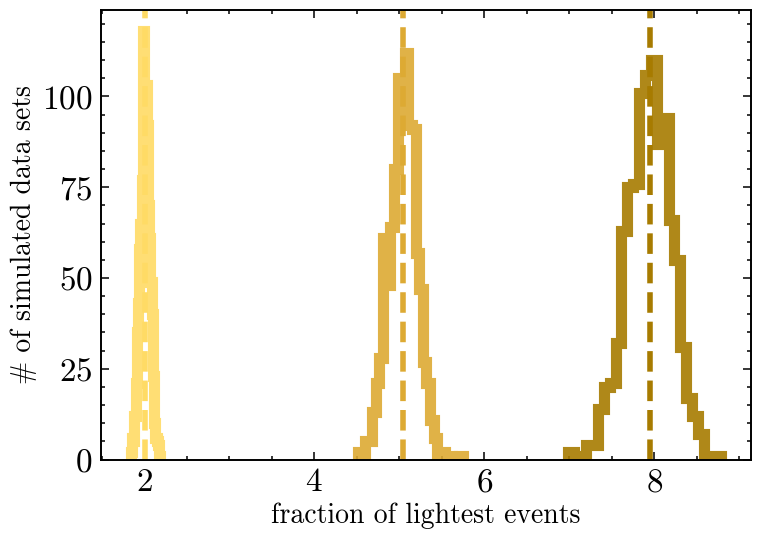

In [9]:
plt.figure(figsize=(10,6))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['SMD'][df['emin'] == ene]
    median = np.median(data)
    mean = np.mean(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', stacked=False, fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9)
    plt.axvline(median, ls='--', lw=4,
                 label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.2f} ({p16:.2f}, {p84:.2f})',
                 color=colors[f'{ene}'])
    print(f"{ene} EeV light median: {median:.3f}, 68% interval: [{p16:.3f}, {p84:.3f}], mean: {mean:.3f}")

# plt.legend(fontsize='x-small')
plt.xlabel(r'fraction of lightest events')
plt.ylabel('# of simulated data sets')
# plt.ylim(0, 600)
plt.show()

### Discovery potential based on a subset

In [10]:
dd = file_loader('AixNet_EPOS_old')
mass_mask = mf.extract_all_fractions(np.log10(dd['energy'])+18, dd['mass']) 
print(dd['mass'])
dd = dict_cutter(dd, mass_mask)
colors = {'p': 'red', 'He': 'orange', 'CNO': 'green', 'Fe': 'blue'}
print((dd['energy']))

[ 1.  1.  1. ... 56. 56. 56.]
[  2.81467     2.35537     1.6274699 ... 154.976     127.214005
 147.363    ]


red
orange
green
blue


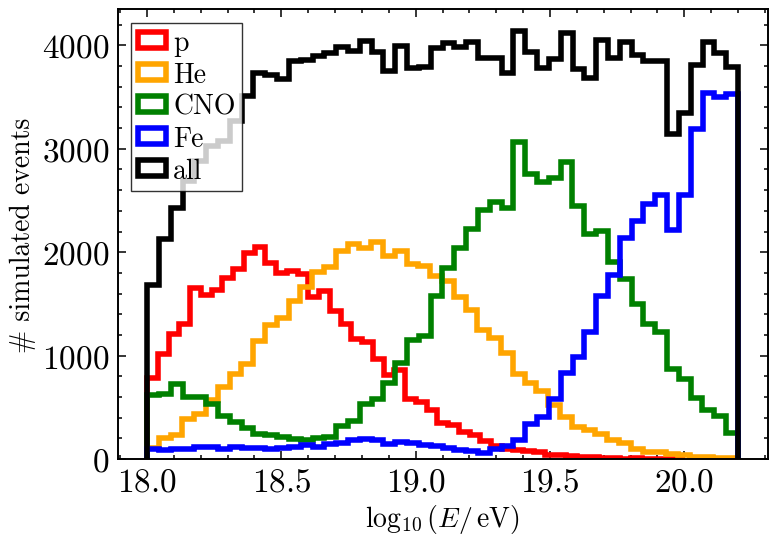

182935
21836


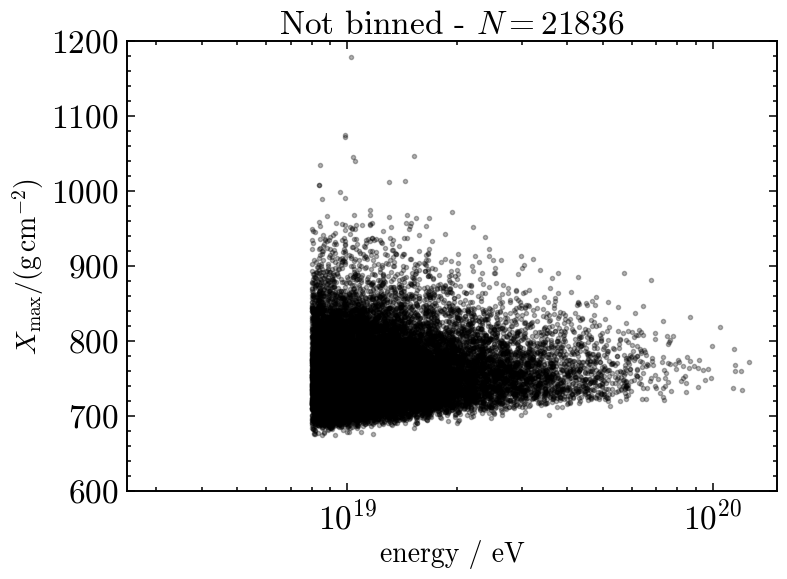

Remaining events above 8 EeV: 21836


In [ ]:
plt.figure(figsize=(10,6)) 
for name in names:
    print(colors[name])
    plt.hist(np.log10(dd['energy'][dd['mass']==names[name]]*1e18), histtype='step', fill=False, lw=4, color=colors[name], label=f'{name}', bins=50)
plt.hist(np.log10(dd['energy']*1e18), histtype='step', stacked=False, fill=False, color='k', lw=4, label='all', bins=50)
plt.xlabel(r'$\log_{10}(E/\, \mathrm{eV})$')
plt.ylabel(r'# simulated events')
plt.legend()
plt.show()
print(len(dd['energy']))

energy_mask = (dd['energy']>=8)
dd = dict_cutter(dd, energy_mask)
spectrum_mask = es.spectrum_fraction(dd['energy'])
dd = dict_cutter(dd, spectrum_mask)
print(len(dd['energy']))

#dd = dict_paster(temp_dict)

dd['charge'] = np.empty_like(dd['mass'])
for mass in names:
    dd['charge'][np.where(dd['mass']==names[mass])]=charges[mass]

plt.figure(figsize=(10,6))
plt.title(f'Not binned - $N ={len(dd['energy']):.0f}$')
plt.scatter(dd['energy']*1e18, dd['dnn_xmax'], alpha=0.3, color='k')
plt.xlabel(r'energy / eV')
plt.ylabel(r'$X_\mathrm{max} / \mathrm{(g \, cm^{-2})}$')
plt.xscale('log')
plt.ylim(600, 1200)
plt.xlim(2.5e18, 150e18)
plt.show()

print('Remaining events above 8 EeV:', len(dd['energy'][dd['energy']>=8]))
generate_xmax19(dd, 'dnn_xmax', 'energy')

Energy bin: 8-16 EeV
Number of events in bin:  16287
Number of events in light bin:  3395
Number of events in heavy bin:  6215
Light dipole amplitude: 0.119 pm 0.024
Heavy dipole amplitude: 0.039 pm 0.018

Energy bin: 16-32 EeV
Number of events in bin:  4532
Number of events in light bin:  607
Number of events in heavy bin:  2300
Light dipole amplitude: 0.268 pm 0.057
Heavy dipole amplitude: 0.058 pm 0.029

Energy bin: 32-200 EeV
Number of events in bin:  1017
Number of events in light bin:  82
Number of events in heavy bin:  504
Light dipole amplitude: 0.332 pm 0.156
Heavy dipole amplitude: 0.044 pm 0.063



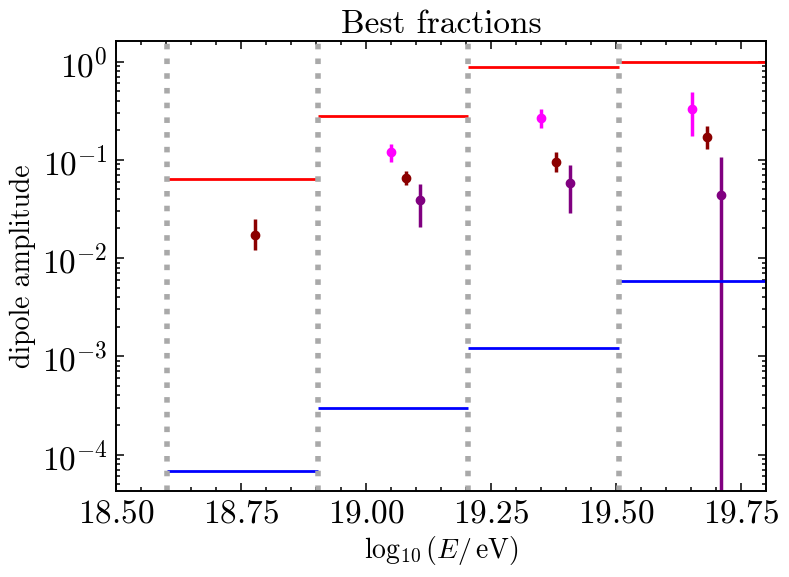

In [12]:
energies = np.array([4e18, 8e18, 16e18, 32e18, 200e18])
# print(dip.beta_r)

plt.figure(figsize=(10,6))
plt.title(r'Best fractions')
for i in range(len(energies[:-1])):

    if i>=1:
        e_min = energies[i]/1e18
        e_max =energies[i+1]/1e18
        e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
        data = dict_cutter(dd, e_mask)
        print(f'Energy bin: {e_min:.0f}-{e_max:.0f} EeV')
        print('Number of events in bin: ', len(data['energy']))
        mask_h = (data['xmax19']<heavy_thres[i-1])
        mask_l = (data['xmax19']>light_thres[i-1])
        light_frac = dict_cutter(data, mask_l)
        heavy_frac = dict_cutter(data, mask_h)
        print('Number of events in light bin: ', len(light_frac['energy']))
        print('Number of events in heavy bin: ', len(heavy_frac['energy']))
        dip_l, err_l = smd.dipole_value(light_frac['energy'],light_frac['charge'], d_max=d_max)
        dip_h, err_h = smd.dipole_value(heavy_frac['energy'], heavy_frac['charge'], d_max=d_max)
        print(f'Light dipole amplitude: {dip_l:.3f} pm {err_l:.3f}')
        print(f'Heavy dipole amplitude: {dip_h:.3f} pm {err_h:.3f}')
        print()
        plt.errorbar(np.log10(1.4*mid_ene[i]), dip_l, yerr=err_l, ls='', marker='o', color='fuchsia')
        plt.errorbar(np.log10(1.6*mid_ene[i]), dip_h, yerr=err_h, ls='', marker='o', color='purple')

    E = energies[i]
    Eplus = energies[i+1]
    enetwo = np.linspace(E, Eplus)
    Z_sum_Fe = np.zeros_like(enetwo)
    Z_sum_p = np.zeros_like(enetwo)
    for name in charges:
        if name == 'Fe':
            Z_sum_Fe = dip.dipole_dependence(name, enetwo/1e18, d_max)# *(1 - (mf.fraction_func('p', np.log10(enetwo)) + mf.fraction_func('He', np.log10(enetwo)) + mf.fraction_func('CNO', np.log10(enetwo))))
        if name == 'p':
            Z_sum_p = dip.dipole_dependence(name, enetwo/1e18, d_max)# *mf.fraction_func(name, np.log10(enetwo))
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum_Fe)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=2, color='blue')
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum_p)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=2, color='red')
    plt.axvline(np.log10(E), lw=4, color='darkgrey', ls=':')
plt.errorbar(np.log10(1.5*mid_ene), dipole_values, yerr=dipole_errors, ls='', marker='o', color='darkred')
plt.xlabel(r'$\log_{10}(E/\, \mathrm{eV})$')
plt.ylabel('dipole amplitude')
plt.xlim(18.5, 19.8)
#plt.xlim(18.5, 20.2)
plt.yscale('log')
# plt.legend(loc='upper left')
plt.show()

[4.0e+18 8.0e+18 1.6e+19 3.2e+19 2.0e+20]
5
[6114, 2331, 11939]
11536


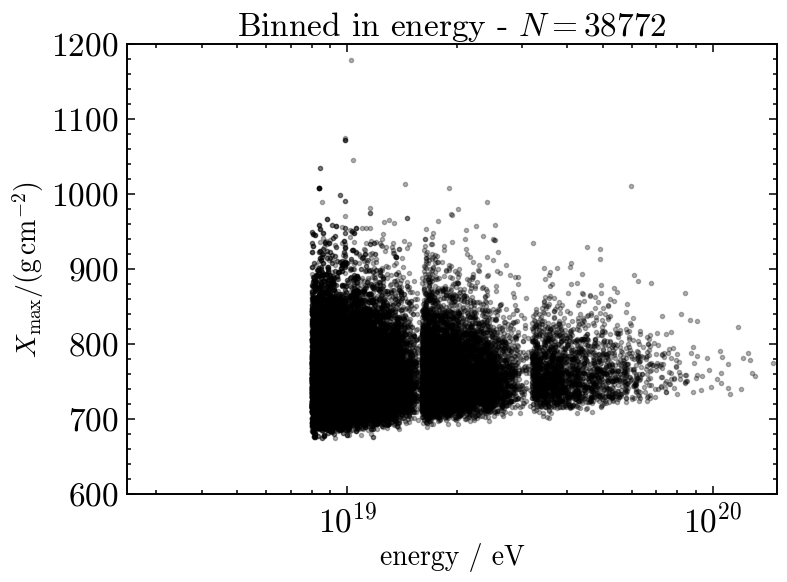

Remaining events above 8 EeV: 38772


In [ ]:
dd = file_loader('AixNet_EPOS_old')
mass_mask = mf.extract_all_fractions(np.log10(dd['energy'])+18, dd['mass']) 
dd = dict_cutter(dd, mass_mask)

temp_dict = [{} for i in range(5)] # first bin needs to be drawn three times

print(energies)
for i in range(len(energies[:-2])):
    enne = energies[i+1]/1e18
    enneplus = energies[i+2]/1e18
    energy_mask = (dd['energy']>=enne)&(dd['energy']<enneplus)
    temp_dict[i] = dict_cutter(dd, energy_mask)
    spectrum_mask = es.spectrum_fraction(temp_dict[i]['energy'])
    temp_dict[i] = dict_cutter(temp_dict[i], spectrum_mask)
    if i == 0:
        for j in range(2):
            temp_dict[j+3] = dict_cutter(dd, energy_mask)
            spectrum_mask = es.spectrum_fraction(temp_dict[j+3]['energy'])
            temp_dict[j+3] = dict_cutter(temp_dict[j+3], spectrum_mask)

emily_numbers = [28612, 8024, 2136]
events_to_remove = [len(temp_dict[0]['energy'])+len(temp_dict[3]['energy'])+len(temp_dict[4]['energy'])-28612, len(temp_dict[1]['energy'])-8024, len(temp_dict[2]['energy'])-2136]
print(len(temp_dict))
print(events_to_remove)
print(len(temp_dict[4]['energy']))
dd = dict_paster(temp_dict)
emily_mask = get_emilys_numbers(dd, energies, events_to_remove)
dd = dict_cutter(dd, emily_mask)

dd['charge'] = np.empty_like(dd['mass'])
for mass in names:
    dd['charge'][np.where(dd['mass']==names[mass])]=charges[mass]

plt.figure(figsize=(10,6))
plt.title(f'Binned in energy - $N ={len(dd['energy'][dd['energy']>=8]):.0f}$')
plt.scatter(dd['energy'][dd['energy']>=8]*1e18, dd['dnn_xmax'][dd['energy']>=8], alpha=0.3, color='k')
plt.xlabel(r'energy / eV')
plt.ylabel(r'$X_\mathrm{max} / \mathrm{(g \, cm^{-2})}$')
plt.xscale('log')
plt.ylim(600, 1200)
plt.xlim(2.5e18, 150e18)
plt.show()

print('Remaining events above 8 EeV:', len(dd['energy'][dd['energy']>=8]))
print('Remaining events above 8 EeV:', len(dd['energy'][(dd['energy']>=8)&(dd['energy']<=16)]))

In [14]:
print('Remaining events above 8 EeV:', len(dd['energy'][(dd['energy']>=8)&(dd['energy']<=16)]))

Remaining events above 8 EeV: 28612


Energy bin: 8-16 EeV
Number of events in bin:  28612 , H:  5160 , He:  13915 , O:  8480 , Fe:  1057
Number of events in light bin:  6190 , H:  2318 , He:  3422 , O:  440 , Fe:  10
Number of events in heavy bin:  10478 , H:  772 , He:  3849 , O:  4927 , Fe:  930
Light dipole amplitude: 0.112 pm 0.018
Heavy dipole amplitude: 0.037 pm 0.014

Energy bin: 16-32 EeV
Number of events in bin:  8024 , H:  358 , He:  2399 , O:  5039 , Fe:  228
Number of events in light bin:  1160 , H:  181 , He:  720 , O:  259 , Fe:  0
Number of events in heavy bin:  3973 , H:  50 , He:  615 , O:  3102 , Fe:  206
Light dipole amplitude: 0.259 pm 0.042
Heavy dipole amplitude: 0.054 pm 0.022

Energy bin: 32-200 EeV
Number of events in bin:  2136 , H:  15 , He:  201 , O:  1294 , Fe:  626
Number of events in light bin:  185 , H:  10 , He:  72 , O:  102 , Fe:  1
Number of events in heavy bin:  1033 , H:  0 , He:  22 , O:  514 , Fe:  497
Light dipole amplitude: 0.412 pm 0.104
Heavy dipole amplitude: 0.051 pm 0.044



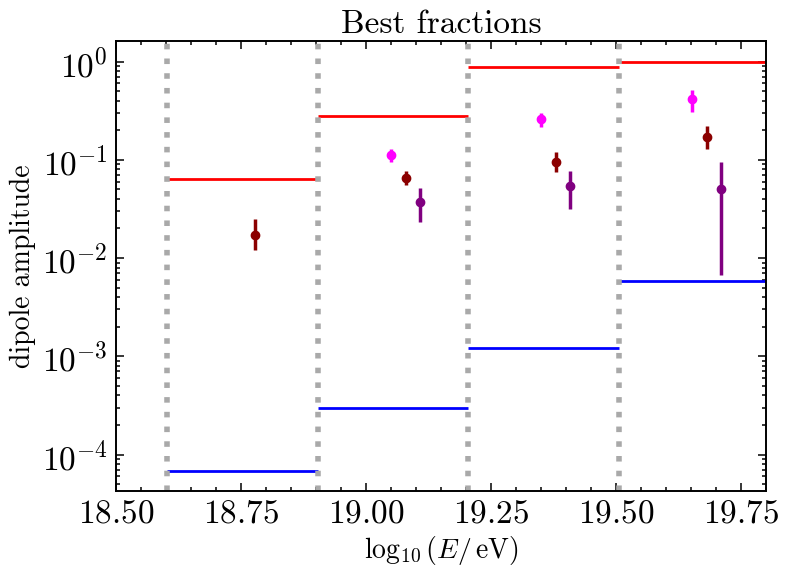

In [18]:
generate_xmax19(dd, 'dnn_xmax', 'energy')

plt.figure(figsize=(10,6))
plt.title(r'Best fractions')
for i in range(len(energies[:-1])):

    if i>=1:
        e_min = energies[i]/1e18
        e_max =energies[i+1]/1e18
        e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
        data = dict_cutter(dd, e_mask)
        print(f'Energy bin: {e_min:.0f}-{e_max:.0f} EeV')
        print('Number of events in bin: ', len(data['energy']),
              ', H: ', len(data['mass'][data['mass']==1]),
              ', He: ', len(data['mass'][data['mass']==4]),
              ', O: ', len(data['mass'][data['mass']==16]),
              ', Fe: ', len(data['mass'][data['mass']==56]))
        mask_h = (data['xmax19']<heavy_thres[i-1])
        mask_l = (data['xmax19']>light_thres[i-1])
        light_frac = dict_cutter(data, mask_l)
        heavy_frac = dict_cutter(data, mask_h)
        print('Number of events in light bin: ', len(light_frac['energy']), 
              ', H: ', len(light_frac['mass'][light_frac['mass']==1]),
              ', He: ', len(light_frac['mass'][light_frac['mass']==4]),
              ', O: ', len(light_frac['mass'][light_frac['mass']==16]),
              ', Fe: ', len(light_frac['mass'][light_frac['mass']==56]))
        print('Number of events in heavy bin: ', len(heavy_frac['energy']),
              ', H: ', len(heavy_frac['mass'][heavy_frac['mass']==1]),
              ', He: ', len(heavy_frac['mass'][heavy_frac['mass']==4]),
              ', O: ', len(heavy_frac['mass'][heavy_frac['mass']==16]),
              ', Fe: ', len(heavy_frac['mass'][heavy_frac['mass']==56]))
        dip_l, err_l = smd.dipole_value(light_frac['energy'],light_frac['charge'], d_max=d_max)
        dip_h, err_h = smd.dipole_value(heavy_frac['energy'], heavy_frac['charge'], d_max=d_max)
        print(f'Light dipole amplitude: {dip_l:.3f} pm {err_l:.3f}')
        print(f'Heavy dipole amplitude: {dip_h:.3f} pm {err_h:.3f}')
        print()
        plt.errorbar(np.log10(1.4*mid_ene[i]), dip_l, yerr=err_l, ls='', marker='o', color='fuchsia')
        plt.errorbar(np.log10(1.6*mid_ene[i]), dip_h, yerr=err_h, ls='', marker='o', color='purple')

    E = energies[i]
    Eplus = energies[i+1]
    enetwo = np.linspace(E, Eplus)
    Z_sum_Fe = np.zeros_like(enetwo)
    Z_sum_p = np.zeros_like(enetwo)
    for name in charges:
        if name == 'Fe':
            Z_sum_Fe = dip.dipole_dependence(name, enetwo/1e18, d_max)# *(1 - (mf.fraction_func('p', np.log10(enetwo)) + mf.fraction_func('He', np.log10(enetwo)) + mf.fraction_func('CNO', np.log10(enetwo))))
        if name == 'p':
            Z_sum_p = dip.dipole_dependence(name, enetwo/1e18, d_max)# *mf.fraction_func(name, np.log10(enetwo))
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum_Fe)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=2, color='blue')
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum_p)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=2, color='red')
    plt.axvline(np.log10(E), lw=4, color='darkgrey', ls=':')
plt.errorbar(np.log10(1.5*mid_ene), dipole_values, yerr=dipole_errors, ls='', marker='o', color='darkred')
plt.xlabel(r'$\log_{10}(E/\, \mathrm{eV})$')
plt.ylabel('dipole amplitude')
plt.xlim(18.5, 19.8)
#plt.xlim(18.5, 20.2)
plt.yscale('log')
# plt.legend(loc='upper left')
plt.show()